## Decision Trees

Decision Trees are a type of supervised learning algorithm that are used for both classification and regression, can be used for multioutput.

Also a fundamental part of Random Forests. 

Trees also dont need feature scaling. 

In [1]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris(as_frame=True)
xIris = iris.data[["petal length (cm)", "petal width (cm)"]].values
yIris = iris.target

treeClass = DecisionTreeClassifier(max_depth=2, random_state=42)
treeClass.fit(xIris, yIris)

DecisionTreeClassifier(max_depth=2, random_state=42)

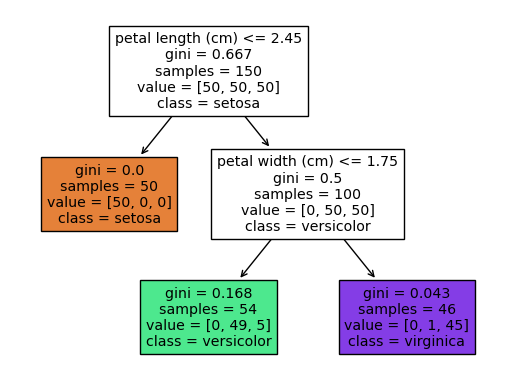

In [2]:
# Visualizing the tree
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plot_tree(treeClass,
          feature_names=["petal length (cm)", "petal width (cm)"],
          class_names=iris.target_names,
          filled=True)

plt.show()

## Making Predictions

To make predictions, the algorithm starts at the root note and works down. If the condition is true, it goes left, and if it is false, it goes right. 

If we have a flower with petal length 3 and width 1, it will fail the first condition, and then succeed on the second condition, and the tree decides on Versicolor.

Node attributes:
- Sample: n training instances that saw that node
- Value: number of instances per class that this node applies to
- gini: Gini impurity score: 0 if all instances in node apply to same class

$$G_i = 1 - \sum_{k=1}^{n} p_{i,k}^2$$

Gi is the gini impurity of the i'th node

P_i,k is the ratio of class k instances among the training instances in the i'th node

In [3]:
treeClass.predict([[5, 1.5]])
treeClass.tree_
# holds info about the tree

# decision trees often have easy to understand rules, 
# unlike random forests or neural nets

# Estimating Class Probabilities

Decision trees can predict probs instance x belongs to class k

- Finds leaf node corresponding to x, then returns % of class k instances going to that node among all instances going to that node




In [4]:
treeClass.predict_proba([[5, 1.5]]).round(2)
# here: 0% for setosa, 91% for versicolor, 9% for virginica

array([[0.  , 0.91, 0.09]])

## CART Training Algorithm

- Classification and Regression Tree
- This is what sklearn uses to train decision trees

Splits training sets into two subsets using some feature k and threshold t<sub>k</sub>, by searching for pair of k and tk that produce the purest subsets, weighted by size.

CART cost function for classification:
$$J(k, t_k) = \frac{m_{\text{left}}}{m} G_{\text{left}} + \frac{m_{\text{right}}}{m} G_{\text{right}}$$

- G left/right is the impurity of the left/right subset
- m left/right is the n instances in left/right subset
- m is mleft + mright

CART does the same thing recursively on both subsets, until it reaches its max_depth hyperparameter or if it cant find a split that reduces impurity


## Computational Complexity

- Making a prediction requires going through O(log2 m) nodes, where m is the number of training instances, so pretty quick
- The training algorithm compares all features on all samples at each node, which results in an O(n x m log2(m)) complexity

Can speed up training and help reduce overfitting by setting max_depth hyperparam, but also be careful to not set it too low or youll underfit

## Gini Impurity vs Entropy

The DecisionTreeClassifier uses gini impurity by default

In [5]:
treeEntropy = DecisionTreeClassifier(criterion="entropy")

Entropy is used commonly as an impurity measure in ML: a set's entropy is 0 when it only has instances from one class

Entropy
$$H_i = -\sum_{\substack{k=1 \\ p_{i,k} \neq 0}}^{n} p_{i,k} \log_2(p_{i,k})$$

log2() is the binarity log, equal to log(x) / log(2)

- Entropy tends to produce slightly more balanced trees, but Gini and entropy produce similar trees

## Regularization Hyperparams

Trees are nonparametric models: number of params not decided prior to training. These models tend to overfit.

Parametric models, ie linear regression, have x number of params. These models can underfit.

All hyperparams:
- max_features: max n features eval'd for splitting per node
- min_samples_split: min samples a node must have b4 splitting
- min_samples_leaf: min samples for a node to be created
- max_leaf_nodes
- min_weight_fraction_leaf: same as min_samples_leaf but as a % 
- min_impurity_decrease: only split if at least this much impurity is lost
- ccp_alpha: controls the pruning algorithm, getting rid of subtrees that dont reduce enough impurity compared to n leaves. more ccp_alpha means more pruning

To limit complexity: increase min_* params or ccp_alpha

Good idea to tune max_depth first, min_samples_leaf/max_features next


In [6]:
from sklearn.datasets import make_moons
Xmoons, ymoons = make_moons(n_samples=150, noise=0.2, random_state=42)
tree1 = DecisionTreeClassifier(random_state=42)
tree2 = DecisionTreeClassifier(min_samples_leaf=5,random_state=42)
tree1.fit(Xmoons, ymoons)
tree2.fit(Xmoons, ymoons)

DecisionTreeClassifier(min_samples_leaf=5, random_state=42)

In [7]:
Xtest, ytest = make_moons(n_samples=1000, noise=0.2, random_state=41)
print("No reg:",tree1.score(Xtest,ytest))
print("Reg:",tree2.score(Xtest,ytest))

No reg: 0.898
Reg: 0.912


## Regression

In [8]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor

rng = np.random.default_rng(seed=42)
Xquad = rng.random((200,1)) - 0.5
yquad = Xquad**2 + .025 * rng.standard_normal((200,1))
# a quadratic dataset with noise

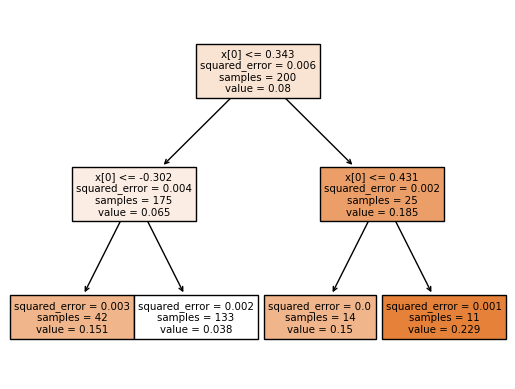

In [9]:
treeReg = DecisionTreeRegressor(max_depth=2, random_state=42)
treeReg.fit(Xquad, yquad)
plot_tree(treeReg, filled=True)
plt.show()

# this is similar to a naive nonparametric regression
# it basically just splits the data into 4 groups and 
# guesses the mean for each group

#### CART Cost Function for Regression

$$J(k, t_k) = \frac{m_{\text{left}}}{m} \text{MSE}_{\text{left}} + \frac{m_{\text{right}}}{m} \text{MSE}_{\text{right}}$$

MSE for each node is:

$$\text{MSE}_{\text{node}} = \frac{1}{m_{\text{node}}} \sum_{i \in \text{node}} (y_i - \hat{y}_{\text{node}})^2$$

and y hat for each node is:

$$\hat{y}_{\text{node}} = \frac{1}{m_{\text{node}}} \sum_{i \in \text{node}} (y_i)$$

In [10]:
# adding regularization helps with regression tasks a lot, as trees
# tend to overfit

### Sensitivity to Axis Orientation

In [11]:
# Biggest issue with trees: they like splits orthogonal to axes
# I.e no diagonal line splits

# Way to fix this: scale data, do a PCA transform (ch 7)

In [16]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pcaPipe = make_pipeline(StandardScaler(), PCA())
Xrotated = pcaPipe.fit_transform(xIris)
treeClf =  DecisionTreeClassifier(max_depth=2, random_state=42)
treeClf.fit(Xrotated, yIris)

# Decision trees support missing vals natively, no need to impute

DecisionTreeClassifier(max_depth=2, random_state=42)

# Decision Trees Have A High Variance

The biggest issue with decision trees is that small changes to hyperparams/data produce very diferent models

Sklearn uses stochastic training, so models trained identically may produce diff results